In [2]:
#Import Libraries 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# Feature Engineering
from sklearn.feature_extraction.text import TfidfVectorizer
import string

# Models
!pip install xgboost
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV

# Imbalance Handling
from imblearn.over_sampling import SMOTE

# Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder


In [ ]:
# Load Dataset
test = pd.read_csv("test_data Cap 2.csv")
train = pd.read_csv("train_data Cap 2.csv")
Hidden = pd.read_csv("test_data_hidden Cap 2.csv")

print(train.shape)
train.head()

In [40]:
#Exploratory Data Analysis (EDA)
print("Shape of Dataset:", train.shape)

print("\nColumns:")
print(train.columns)

print("\nDataset Info:")
print(train.info())

print("\nFirst 5 Rows:")
train.head()

Shape of Dataset: (4000, 8)

Columns:
Index(['Name of the product', 'Product Brand', 'categories',
       'primaryCategories', 'reviews.date', 'reviews.text', 'reviews.title',
       'sentiment'],
      dtype='object')

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Name of the product  4000 non-null   object
 1   Product Brand        4000 non-null   object
 2   categories           4000 non-null   object
 3   primaryCategories    4000 non-null   object
 4   reviews.date         4000 non-null   object
 5   reviews.text         4000 non-null   object
 6   reviews.title        3990 non-null   object
 7   sentiment            4000 non-null   object
dtypes: object(8)
memory usage: 250.1+ KB
None

First 5 Rows:


,Name of the product,Product Brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
0,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2016-12-26T00:00:00.000Z,Purchased on Black FridayPros - Great Price (e...,Powerful tablet,Positive
1,Amazon - Echo Plus w/ Built-In Hub - Silver,Amazon,"Amazon Echo,Smart Home,Networking,Home & Tools...","Electronics,Hardware",2018-01-17T00:00:00.000Z,I purchased two Amazon in Echo Plus and two do...,Amazon Echo Plus AWESOME,Positive
2,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Amazon Echo,Virtual Assistant Speakers,Electro...","Electronics,Hardware",2017-12-20T00:00:00.000Z,Just an average Alexa option. Does show a few ...,Average,Neutral
3,"Fire HD 10 Tablet, 10.1 HD Display, Wi-Fi, 16 ...",Amazon,"eBook Readers,Fire Tablets,Electronics Feature...","Office Supplies,Electronics",2017-08-04T00:00:00.000Z,"very good product. Exactly what I wanted, and ...",Greattttttt,Positive
4,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-01-23T00:00:00.000Z,This is the 3rd one I've purchased. I've bough...,Very durable!,Positive


In [41]:
#Check Missing Values
print("\nMissing Values:")
print(train.isnull().sum())


Missing Values:
Name of the product     0
Product Brand           0
categories              0
primaryCategories       0
reviews.date            0
reviews.text            0
reviews.title          10
sentiment               0
dtype: int64



Sentiment Count:
sentiment
Positive    3749
Neutral      158
Negative      93
Name: count, dtype: int64


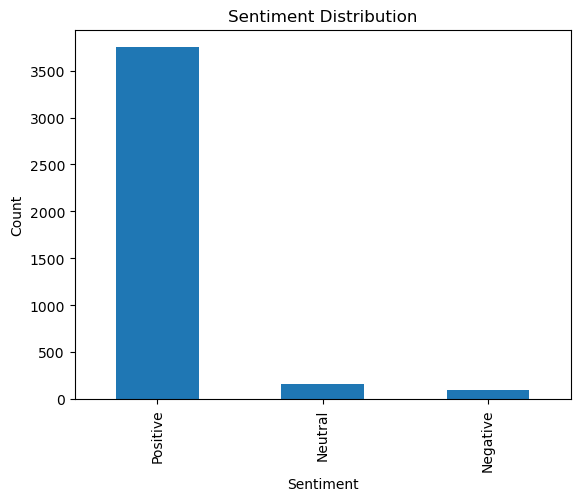

In [42]:
#Sentiment Distribution (Class Imbalance Check)\
import matplotlib.pyplot as plt

print("\nSentiment Count:")
print(train['sentiment'].value_counts())

plt.figure()
train['sentiment'].value_counts().plot(kind='bar')
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


Review Length Statistics:
count    4000.000000
mean      159.400750
std       216.209085
min        45.000000
25%        70.000000
50%       105.000000
75%       182.000000
max      8351.000000
Name: review_length, dtype: float64


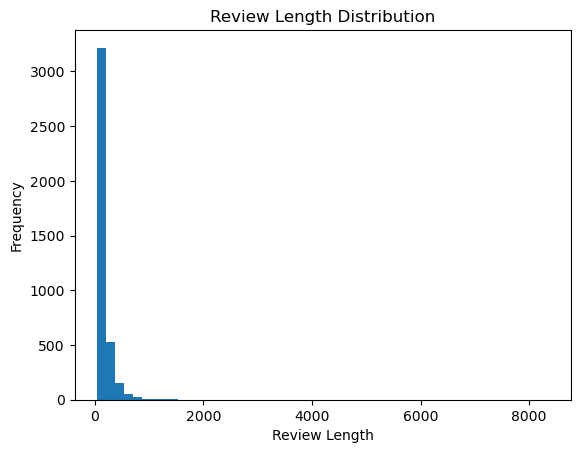

In [43]:
#. Review Length Analysis
train['review_length'] = train['reviews.text'].astype(str).apply(len)

print("\nReview Length Statistics:")
print(train['review_length'].describe())

plt.figure()
plt.hist(train['review_length'], bins=50)
plt.title("Review Length Distribution")
plt.xlabel("Review Length")
plt.ylabel("Frequency")
plt.show()


Brand vs Sentiment:
sentiment      Negative  Neutral  Positive
Product Brand                             
Amazon               93      158      3749


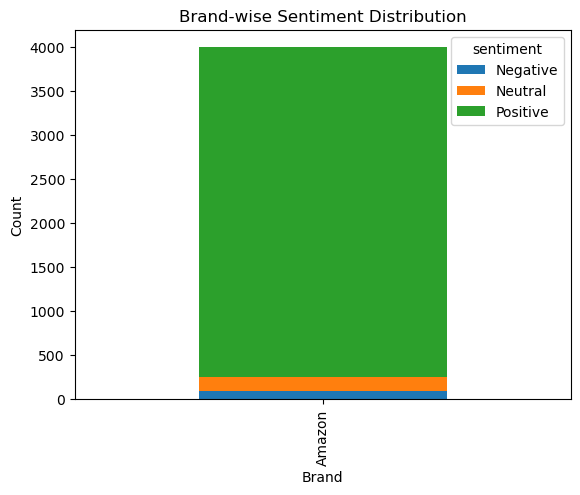

In [44]:
#. Brand-wise Sentiment Analysis
brand_sentiment = pd.crosstab(train['Product Brand'], train['sentiment'])

print("\nBrand vs Sentiment:")
print(brand_sentiment.head())

brand_sentiment.plot(kind='bar', stacked=True)
plt.title("Brand-wise Sentiment Distribution")
plt.xlabel("Brand")
plt.ylabel("Count")
plt.show()


Category vs Sentiment:
sentiment                    Negative  Neutral  Positive
primaryCategories                                       
Electronics                        71      115      2414
Electronics,Hardware               19       32      1108
Electronics,Media                   0        0        17
Office Supplies,Electronics         3       11       210


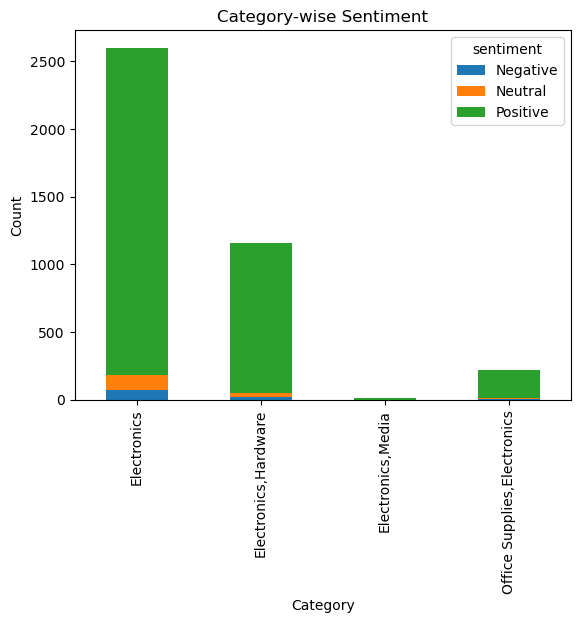

In [45]:
#Category Analysis
category_sentiment = pd.crosstab(train['primaryCategories'], train['sentiment'])

print("\nCategory vs Sentiment:")
print(category_sentiment.head())

category_sentiment.plot(kind='bar', stacked=True)
plt.title("Category-wise Sentiment")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()


Reviews per Year:
Year
2014       9
2015      42
2016    1067
2017    2295
2018     587
Name: count, dtype: int64


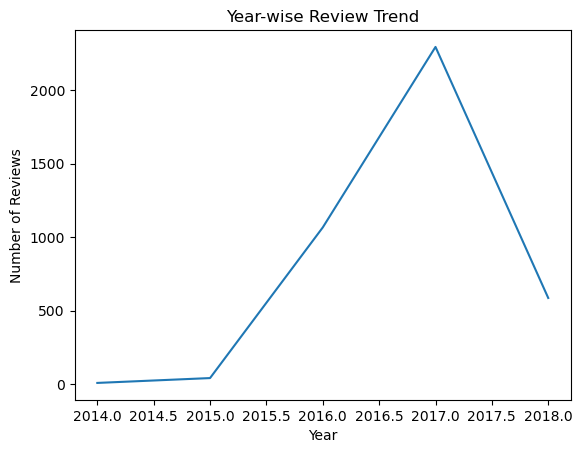

In [46]:
#Time-based Review Analysis
train['reviews.date'] = pd.to_datetime(train['reviews.date'], errors='coerce')

train['Year'] = train['reviews.date'].dt.year

yearly_reviews = train['Year'].value_counts().sort_index()

print("\nReviews per Year:")
print(yearly_reviews)

plt.figure()
yearly_reviews.plot(kind='line')
plt.title("Year-wise Review Trend")
plt.xlabel("Year")
plt.ylabel("Number of Reviews")
plt.show()

In [57]:
#Text Preprocessing
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

train['clean_review'] = train['reviews.text'].apply(clean_text)

In [58]:
#TF-IDF Feature Engineering
from sklearn.preprocessing import LabelEncoder
tfidf = TfidfVectorizer(max_features=5000)

X = tfidf.fit_transform(train['clean_review'])
y = train['sentiment']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [53]:
#Train Model WITHOUT Handling Imbalance
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

y_pred = nb_model.predict(X_test)

print("Accuracy (Before SMOTE):", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

Accuracy (Before SMOTE): 0.93875

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.00      0.00      0.00        36
           2       0.94      1.00      0.97       751

    accuracy                           0.94       800
   macro avg       0.31      0.33      0.32       800
weighted avg       0.88      0.94      0.91       800



C:\Users\17506\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\17506\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\17506\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [54]:
#Handle Class Imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y_encoded)

print("After SMOTE Distribution:\n")
print(pd.Series(y_resampled).value_counts())

After SMOTE Distribution:

2    3749
1    3749
0    3749
Name: count, dtype: int64


In [55]:
#Train Model AFTER SMOTE
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_resampled, y_resampled,
    test_size=0.2,
    random_state=42
)

nb_model_s = MultinomialNB()
nb_model_s.fit(X_train_s, y_train_s)

y_pred_s = nb_model_s.predict(X_test_s)

print("Accuracy (After SMOTE):", accuracy_score(y_test_s, y_pred_s))
print("\nClassification Report:\n")
print(classification_report(y_test_s, y_pred_s))

Accuracy (After SMOTE): 0.9626666666666667

Classification Report:

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       748
           1       0.94      0.99      0.96       733
           2       0.99      0.90      0.94       769

    accuracy                           0.96      2250
   macro avg       0.96      0.96      0.96      2250
weighted avg       0.96      0.96      0.96      2250



In [56]:
#Confusion Matrix
print("Confusion Matrix:\n")
print(confusion_matrix(y_test_s, y_pred_s))

Confusion Matrix:

[[748   0   0]
 [  0 726   7]
 [ 30  47 692]]


In [59]:
#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

In [61]:
#Week 3–4 Model 1: Multi-class SVM
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.9915555555555555
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       748
           1       0.98      1.00      0.99       733
           2       1.00      0.98      0.99       769

    accuracy                           0.99      2250
   macro avg       0.99      0.99      0.99      2250
weighted avg       0.99      0.99      0.99      2250



In [62]:
#Model 2: XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

C:\Users\17506\AppData\Local\anaconda3\Lib\site-packages\xgboost\training.py:200: UserWarning: [11:54:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.9866666666666667
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       748
           1       0.98      0.99      0.99       733
           2       0.98      0.98      0.98       769

    accuracy                           0.99      2250
   macro avg       0.99      0.99      0.99      2250
weighted avg       0.99      0.99      0.99      2250



In [67]:
# LSTM Model (Deep Learning)
# Tokenization
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train['clean_review'])

X_seq = tokenizer.texts_to_sequences(train['clean_review'])
X_pad = pad_sequences(X_seq, maxlen=100)

# Encode target
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(train['Sentiment'])

# Split
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(
    X_pad, y_encoded, test_size=0.2, random_state=42
)

# LSTM Model
model = Sequential()
model.add(Embedding(5000, 128, input_length=100))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X_train_dl, y_train_dl, epochs=5, batch_size=32)

loss, acc = model.evaluate(X_test_dl, y_test_dl)
print("LSTM Accuracy:", acc)

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
streamlit 1.37.1 requires protobuf<6,>=3.20, but you have protobuf 6.33.5 which is incompatible.


  Using cached tensorflow-2.20.0-cp312-cp312-win_amd64.whl.metadata (4.6 kB)
  Using cached absl_py-2.4.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.12.19-py2.py3-none-any.whl.metadata (1.0 kB)
  Using cached gast-0.7.0-py3-none-any.whl.metadata (1.5 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-6.33.5-cp310-abi3-win_amd64.whl.metadata (593 bytes)
  Using cached termcolor-3.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached grpcio-1.78.1-cp312-cp312-win_amd64.whl.metadata (3.9 kB)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.13.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached ml_dtypes-0.5.4-cp312-cp312-win_amd64.whl.metadata (9.2 kB)
  Using cached

NameError: name 'pad_sequences' is not defined

In [68]:
#Topic Modeling (LDA)
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx}:")
    print([tfidf.get_feature_names_out()[i] for i in topic.argsort()[-10:]])

Topic 0:
['with', 'my', 'this', 'great', 'for', 'is', 'it', 'and', 'to', 'the']
Topic 1:
['old', 'bought', 'this', 'and', 'he', 'she', 'my', 'loves', 'it', 'for']
Topic 2:
['fiance', 'responds', 'programs', 'item', 'complicated', 'shop', 'facebook', 'neat', 'viewing', 'email']
Topic 3:
['mothers', 'hrs', 'thinner', 'expense', 'responses', 'hugh', 'lap', 'reports', 'downloads', 'replaces']
Topic 4:
['sister', 'social', 'strong', 'anybody', 'teenage', 'edition', 'pink', 'holidays', 'toddler', 'grandkids']
